# Part 3 - A mixture of everything

**ETA** : 20-60 min

**Main Topics** : 
* Spatial Enrichment of biological pathways
* Expression by distance
* Increased spatial resolution


**Information** : This final part will not adhere to the same structured workflow as the two previous parts, rather it's designed to _expose_ you to some different ideas or concepts that could be applied to (theoretically) any type of spatial data. These examples are also specifically chosen to be more restricted to spatial data and not really applicable to single cell data, to further contrast the two techniques. You can jump between the topics as you prefer, likely, you will not be able to complete all of them.

In order to not bore you to death using the same data over and over again, we'll also swtich from Human breast cancer to a slightly different tissue, namely mouse brain.

**Data** : Mouse Brain (Sagittal Posterior). Accessible at 10X Genomics [website][1].


[1]:http://cf.10xgenomics.com/samples/spatial-exp/1.0.0/V1_Mouse_Brain_Sagittal_Posterior_Section_2/V1_Mouse_Brain_Sagittal_Posterior_Section_2_web_summary.html

In [3]:
#------NON-CONCEPTUAL------#
# begin by loading the different packages that we will be using


import anndata as ad
import numpy as np
import pandas as pd

import funcs as f

import matplotlib.pyplot as plt

from typing import Tuple,Union, List, Dict

import torch as t
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import anndata as ad
from scipy.spatial.distance import cdist


from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [4]:
# load data; we will begin with just one sample for the sake of convenience 
data_pths = dict(sample_1 = "../data/mouse-brain/curated/mouse-brain.h5ad")
data = ad.read_h5ad(data_pths["sample_1"])


## Assessing the data

Just to give you some context, we'll quickly assess the data to see what spatial structures of interest we may find. We wil follow the same procedure as in Part 1 and 2:

1. Inspect the data object
2. Inspect the spatial arrangment of the spots
3. Normalize, Reduce Dimensionality, Cluster the data based on gene expression

Since we've been through this procedure before, I'll be sparse with comments.

In [5]:
# We inspect the data object just to make sure everythin loaded correctly
display(data)

AnnData object with n_obs × n_vars = 3293 × 31017
    obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y'
    var: 'name', 'id', 'n_counts'
    uns: 'fiducial_diameter_fullres', 'image_hires', 'spot_diameter_fullres', 'tissue_hires_scalef'

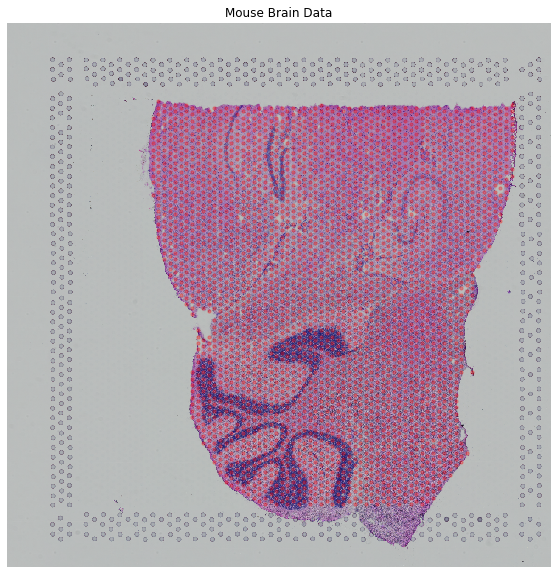

In [6]:
# Next, we visualize the data (HE image and spots)
# to get an idea of what tissue we are actually working with
fig,ax = plt.subplots(1,1,
                      figsize = (20,10))

plt_args = {"s":10, "c":"red",
            "alpha":0.3}

f.plot_data(ax,
            data,
            title = "Mouse Brain Data",
            show_image=True,
            plt_args = plt_args,
           )
plt.show()

Finally we cluster the data, using the same procedure as before, and albeit our objective is not to study the clusters, it will serve as a good reference for some of the forthcoming analysis. This is a slightly more complex tissue, so I've set the number of `gmm_components` to `10` here.

In [336]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans as km
from sklearn.decomposition import PCA
import umap

# set a random seed for reproducibility
np.random.seed(1337)

# normalize the expression data
y = f.naive_normalize(data.X)
# specify number of principal components to use in PCA, feel free to change!
pca_components = 20
# run PCA
y = PCA(n_components = pca_components).fit_transform(y)
# run UMAP
y = umap.UMAP(n_components = 2).fit_transform(y)
# specify the number of components in the GMM, feel free to change!
gmm_components  = 10
# fit GMM to the data
fitted_gmm = GMM(n_components = gmm_components).fit(y)
# get component weights for each spot, "soft labels"
labels_soft = fitted_gmm.predict_proba(y)
# get hard labels for each spot
labels_hard = np.argmax(labels_soft,
                        axis = 1)

As before we visualize the results :

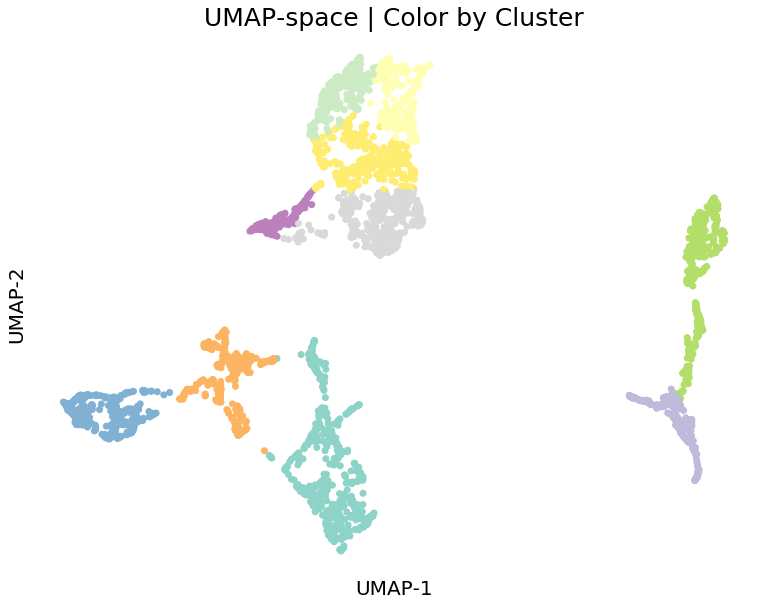

In [337]:
fig,ax = plt.subplots(nrows = 1,
                      ncols = 1,
                      figsize = (20,10))

# plot embedded data, color by hard labels
sc = ax.scatter(y[:,0],
           y[:,1],
           c = labels_hard,
           cmap = plt.cm.Set3,
          )
ax.set_aspect("equal")

ax.set_xlabel("UMAP-1",
                     fontsize = 20)
ax.set_ylabel("UMAP-2",
                     fontsize = 20)

f.clean_ax(ax)

    
ax.set_title("UMAP-space | Color by Cluster",
                fontsize = 25)

plt.show()

Finally we overlay the clusters on the tissue

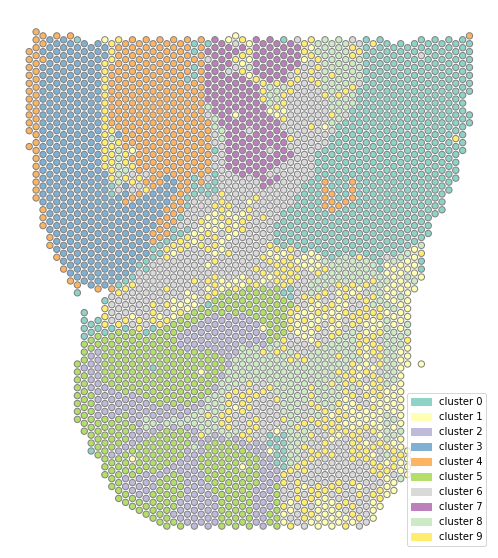

In [338]:
import matplotlib.patches as mpatches

fig,ax = plt.subplots(nrows = 1,
                      ncols = 1,
                      figsize = (10,
                                 10))


f.plot_data(ax,
            data,
            plt_args = {"c":labels_hard,
                        "cmap":plt.cm.Set3,
                        "s":40,
                        "alpha":1,
                        "edgecolor":"gray",
                       },
            show_image = False,
           )

patches = list()
uni = np.unique(labels_hard)
for cl in uni:
    patches.append(mpatches.Patch(color=plt.cm.Set3(cl / uni.max()),
                                  label = "cluster {}".format(cl)))
ax.legend(handles = patches)
plt.show()

Now we know what the tissue looks like and what sort of spatial domains/patterns we might expect to see in our analysis.

## Spatial Gene Enrichment

One question that tend to naturally arise when working with spatial data is whether there are any regions in the tissue that are _enriched_ for a certain biological pathway. We saw in Part 1 how we could first cluster the spatial data, and the subject each cluster to functional enrichment analysis (using `g:Profiler`). This approach however operates on a cluster-level, which deducts a lot of our spatial resolution; it would be more optimal if we could relate an enrichment score to each spatial location.


Suppose we have a particular interest for the GO-term `GO:0097060` (GO Cellular Component - Synaptic Membrane) is spatially enriched. Let the $n_{top}$ genes in sport $s$ constitute a set $T_s$ and the genes in our set of interest be denoted $G$ (containing the genes associated with the GO-term). Next, we look at the intersection between our two gene sets, i.e., $T_s \cap G$. 

We can then compute how likely we are to observe an intersection of the given size by chance, resulting in a p-value which may be used to assign a form of _enrichment score_ to each spot. More explicitly, we use Fischer's Exact test to obtain this p-value. The enrichment score is then defined as :

\begin{equation}
    E_s = -\log10(p(T_s \cap G))
\end{equation}


In [370]:
from scipy.stats import fisher_exact as fe



def enrichment_score(data : ad.AnnData,
                     genes : List[str],
                     n_top : float = 100,
                    )->np.ndarray:
    
    def _assemble_matrix(T : List[str],
                     G : List[str],
                     A : List[str],
                    )->np.ndarray:
        t = set(T)
        g = set(G)
        a = set(A)

        t_and_g = len(t.intersection(g))
        t_not_g = len(t.difference(g))
        g_not_t = len(g.difference(t))
        not_t_not_g = len(a.difference(t.union(g)))

        mat = np.array([[t_and_g,t_not_g],
                        [g_not_t,not_t_not_g]])
        return mat
    
    all_genes = data.var["name"].values
    gene_sums = np.sum(data.X, axis = 0)
    keep_genes = gene_sums > 0
    all_genes = all_genes[keep_genes]
    gene_sums = [keep_genes]
    
    escore = list()
    for s in range(data.shape[0]):
        expr = data.X[s,keep_genes]
        srt = np.argsort(expr)[::-1]
        
        cmat = _assemble_matrix(all_genes[srt[0:n_top]]\
                                .tolist(),
                                genes,
                                all_genes,
                               )
        _,pval = fe(cmat)
        escore.append(-np.log10(pval))
        
    escore = np.array(escore)
    
    return escore
        
        
                    

    
    

In [391]:
go_terms_pth = {"GO:0097060" : "rsc/go-0097060.csv",
                "GO:0042063" : "rsc/go-0042063.csv",
                "GO:0045202" : "rsc/go-0045202.csv",
               }
                    
go_terms = pd.read_csv(go_terms_pth["GO:0097060"],
                       sep = ',',
                       header = 0,
                       index_col = 0,
                      )
go_terms = go_terms["name"]\
                    .values\
                    .tolist()

In [392]:
score = enrichment_score(data,
                         go_terms,
                         n_top = 100)

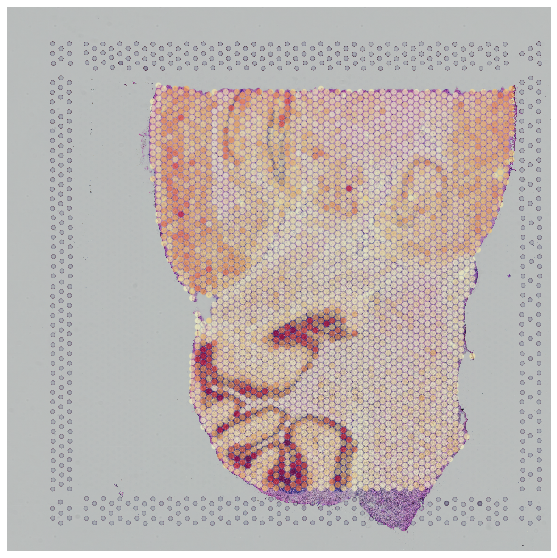

In [395]:
fig,ax = plt.subplots(1,1, figsize = (10,10))
f.plot_data(ax,
            data,
            plt_args = dict(c = score,
                            cmap = plt.cm.YlOrRd,
                            s = 35,
                            edgecolor = "none",
                            alpha = 0.6,
                           ),
           show_image = True,
           )

This type of analysis is very much _flipping_ the question - rather than having a pre-defined set of spots and asking "_which gene sets are enriched within my set_", we formulate the much more targeted question "_where is this gene set enriched_". Both procedures are of course valid, but the former is  more prone to confirmation bias; testing against tens of thousands of pathways and finding one pathway that confirms your hypothesis should not be considered as equally strong evidence as **first stating** that "_if X is true then pathway P is should be enriched in this region_" and then proving that such is the case.

I've added some additional gene sets to the one we looked at above, you can see how they are spatially enriched by simply changing the key `"GO:0097060"` in `go_terms_pth["GO:0097060"]` to any of:

* "GO:0097060"
* "GO:0042063"
* "GO:0045202"

and then just rerun the cells above. 

## Expression as a function of distance

What is really neat with spatial data, is that it allows us to relate our observation in not only the expression-space (like single cell data) but also in the physical domain. Here we'll do a quick exploration of one of the ways by which this could be further taken advantage of.

To motivate the upcoming analysis: 

Let us revisit the previously used breast cancer data set. Suppose we had a pathologist annotating the regions of our tissue as *tumor* or *non-tumor* based on the visual information contained within the HE-image. Since the image is matched with our spatial locations, this would indirectly mean that every spot was also asigned one of these images (inherited from the region which they fall within). 

With this information we could look at how the expression of certain genes vary based on the distance from the tumor/non-tumor interface. Hence we coul characterize the expression 



## Increased Spatial Resolution 

Now, jumping back to the initial data assessment; imagine we are interested in one of the cluster, say `cluster 3` and decide to do a DE analysis to see which genes that are associated with this particular domain (for this we use the same DE test function as in Part 1).

In [11]:
dge_res = f.dge_test(data,
                     labels_hard,
                     contrast = 3)

We then inspect our results:

In [12]:
display(dge_res.head(10))

pval       pval_adj      l2fc  sig
Satb2          3.867526e-253  8.667127e-250  4.265583    1
Tbr1           9.659657e-204  1.082365e-200  3.202900    1
1110008P14Rik  1.557404e-166  1.163381e-163  1.672692    1
3110035E14Rik  6.253155e-157  3.503330e-154  2.691313    1
Ngef           1.364883e-142  6.117405e-140  2.035098    1
Pde1a          4.923627e-130  1.576264e-127  1.928803    1
Chn1           1.294569e-126  3.626411e-124  1.359183    1
Fhl2           1.935718e-115  4.819939e-113  2.229242    1
Kcnq5          8.977902e-107  2.011948e-104  2.227114    1
Ier5           1.712872e-105  3.489588e-103  1.851831    1

So the gene `Satb2` seems to be upregulated in `cluster 3`. To confirm this we visualize the expression of said gene:

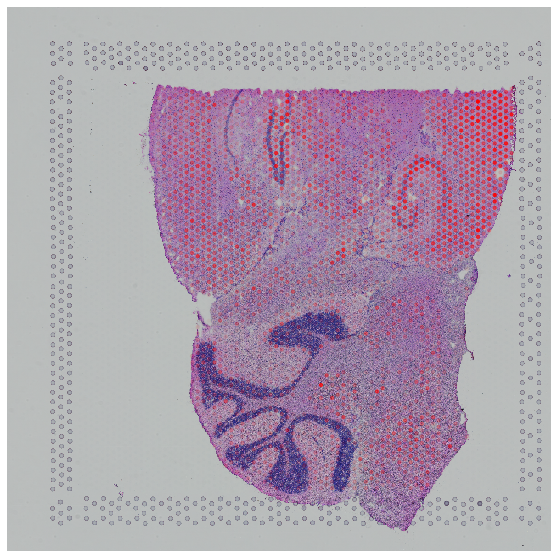

In [182]:
fig,ax = plt.subplots(1,1, figsize = (10,10))
f.plot_data(ax,
            data,
            feature=["name","Satb2"],
            plt_args = dict(cmap = "feature",s = 10))

The expression seems to align well with the cluster, but it's a very sparse pattern, which makes it hard for us to distinguish any precise features. We therfore pose the question of whether we could learn the spatial structure of our data and then "fill in the gaps"; both inbetween the spots and in those locations where we might have a dropout (i.e. transcripts were not captured even though present). 



As eluded to above, the what we would like to do is to somehow learn the spatial structure of our data from the few datapoints that we have observed in order to make an informed statement of the expression at those locations where we are missing data. To predict gene expression in the regions between spots, we could simply do a linear interpolation; something in the spirit of _"take the weighted average of the six nearest neighbours"_ . But what if there are more "long distance" relationships within our tissue, perhaps the expression of one region is informative of a more distant region than it's closest neighbours (a good example of this would be if we had an axis of symmetry present in our tissue)?

In order to account for the expression across the whole tissue and model non-linear relationships we will use a _neural network_ (NN), trained to predict _expression based on location_. The idea is that we train our network with the known locations and expression values, to then predict expression values for new locations (e.g., between the spots). 

<img src="imgs/preds.png" width="50%" height="50%">


I've implemented the network in PyTorch, an open source machine learning library, which provides a neat framwork for buildig your own ML-models. PyTorch (superifcially) shares many features with the (perhaps) more familiar Tensorflow.

As input to our network, we'll compute the euclidean distances between all spots and transform these to more "smooth values" (less prone to blow up our network) by applying a _RBF_ kernel, $(w_s)$. The raw expression values ($x_{gs}$) will also be transformed to new values ($y_{gs}$), according to $y_{gs} = \log2{(x_{gs} + 1.0)}$. Our network has two (fully connected) hidden layers, and uses _Mean Squared Error_ as loss function. I've inentionally tried to make this network very (_very_) tiny, to allow CPU based computing and low memory load.

<img src="imgs/nn.png" width="25%" height="25%">

While PyTorch is fairly easy to use, there's some infrastructure that needs to be put in place. You need a `Dataset` class to hold you data, with two required methods: `__getitem__` and `__len__`. You also need a `fit` function, that performs the actual training. To save you some time, I've already written these components for you - meaning it's more "plug and play"; but do feel free to have a look and explore them. 

Our `Dataset` class will be named `SpatialData`, the function to fit our data is simply named `fit` and the network class `GeneNet`. 


In [215]:
#------NON-CONCEPTUAL------#

class SpatialData(Dataset):
    def __init__(self,
                 data : ad.AnnData,
                 sigma : float = 0.001, 
                 ):


        self.visual = data.uns

        self.sigma = sigma
        self.obs = data.obs.index.values

        self.genes = data.var["name"].tolist()

        self.crd = data.obs[["x","y"]].values

        self.sf = 1

        self.wmat = self.dist_fun(self.crd,
                                  set_sf=True)

        self.max_val = data.X.max()

        expr  = self.normalize_data(data.X)

        self.expr = expr
        self.S = self.expr.shape[0]
        self.G = self.expr.shape[1]

        self.active = 0

        self.g2p  = {self.genes[k]:k for k in range(self.G)}

    def normalize_data(self,
                       x : np.ndarray):
        
        xl = np.log2(x + 1)
        tmp = t.tensor(xl.astype(np.float32))

        return tmp
    

    def dist_fun(self,x : np.ndarray,
                 set_sf : bool = False,
                )-> t.tensor:

        wmat = cdist(x,self.crd)
        if set_sf:
            self.sf = wmat.max()

        wmat = wmat / self.sf

        wmat = np.exp((-(wmat ** 2)/(2*self.sigma)))

        wmat = t.tensor(wmat.astype(np.float32))

        return wmat

    def set_active(self,
                   gene : str,
                   )->None:

        if gene in self.genes:
            self.active = self.g2p[gene]
        else:
            print("not a valid gene name")

    def __getitem__(self,x)->Dict[str,t.tensor]:
        return dict(dist = self.wmat[x,:],
                    expr = self.expr[x,self.active])


    def __len__(self,):
        return self.S
    
    
class GeneNet(nn.Module):
    def __init__(self,
                 input_size,
                 drop_p=0.5,
                 **kwargs,
                 )->None:

        super(GeneNet,self).__init__()
        self.input_size = input_size
        self.drop_p = drop_p

        self.nh1 =  kwargs.get("hidden1",64)
        self.nh2 = kwargs.get("hidden2",32)

        self.fc1 = nn.Linear(self.input_size,
                             self.nh1)

        self.a1 = kwargs.get("activation1",
                             nn.ReLU())
        self.a2 = kwargs.get("activation2",
                             nn.ReLU())


        self.drop = nn.Dropout(p = drop_p)

        self.fc2 = nn.Linear(self.nh1,self.nh2)
        self.fc3 = nn.Linear(self.nh2,1)
        self.out = nn.Softplus()

    def forward(self,
                x : t.tensor,
               )-> t.tensor:
        
        y = self.fc1(x)
        y = self.a1(y)
        y = self.drop(y)
        y = self.fc2(y)
        y = self.a2(y)
        y = self.drop(y)
        y = self.fc3(y)

        return self.out(y.view(-1))


def fit(train_loader : DataLoader,
        model : SpatialData,
        n_epochs : int = 100,
        )->Tuple[SpatialData,List[float]]:

    train_loss = []
    lfun = nn.MSELoss()
    opt = optim.Adam(model.parameters(),
                           lr =0.001)

    model.train()

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch in train_loader:
            opt.zero_grad()
            output = model(batch["dist"])
            
            loss = lfun(output,
                        batch["expr"])
            
            
            loss.backward()
            opt.step()
            epoch_loss += loss.item()

        train_loss.append(epoch_loss)
        if epoch % 100 == 0:
            print("Epoch {} | Loss {}"\
                  .format(epoch,epoch_loss))

    return model,train_loss



The classes above are written as to allow you to play around with the number of nodes and activation functions, but for this initial test, we'll use the following settings:

* 64 nodes in the first hidden layer
* 32 nodes in the second hidden layer
* 500 epochs

To train the network on the gene `Satb2` you need to set this as the "active" gene in the SpatialData object (`xdata`), When that is done, we are ready to assemble and train our network (`net`).

In [216]:
# specify number of epochs (full pass of training data)
t.manual_seed(1337)
n_epochs = 500

# specify number of nodes in the hidden layers
n_h1 = 64
n_h2 = 32

# create a SpatialData object to hold data
xdata = SpatialData(data,
                    sigma=0.01)

batch_size = 1024

# set "Satb2" as the gene to be trained on
xdata.set_active("Satb2")
# define a train loader that feeds data to
# the network (handles batching etc.)
train_loader = DataLoader(xdata,
                        batch_size = batch_size)

# assemble the network
net = GeneNet(input_size = xdata.S,
              drop_p = 0.5,
              hidden1 = n_h1,
              hidden2 = n_h2,
             )


In [217]:
# Train the network!
net,_ = fit(train_loader,
            model = net,
            n_epochs=n_epochs)

Epoch 0 | Loss 1.4650078117847443
Epoch 100 | Loss 0.389049232006073
Epoch 200 | Loss 0.35750461742281914
Epoch 300 | Loss 0.3678104057908058
Epoch 400 | Loss 0.3582431171089411


Great! Now when our network is trained, we can finally use it for our intended purpose; to obtain a higher resolution of the gene expression. Basically, all that needs to be done is to generate a transformed distance vector for each location that we want to predict the expression value at and then pass each of these vectors through our trained vector.  The `Interpolator` class below will do just this for you.

When instatiating an `Interpolator`object, just provide the `SpatialData` object used to train the network, and the number of spots you want along each dimension (if you max out to hard on this, the number of spots, you might expreience some memory Issues). 

In [18]:
class Interpolator:
    def __init__(self,
                 dl : SpatialData,
                 n_points : int = 200,
                 ):

        _x =  np.linspace(dl.crd[:,0].min(),
                          dl.crd[:,0].max(),
                          n_points)

        _y =  np.linspace(dl.crd[:,1].min(),
                          dl.crd[:,1].max(),
                          n_points)


        _x,_y = np.meshgrid(_x,_y)
        self.crd = np.hstack((_x.reshape(-1,1),
                              _y.reshape(-1,1)))

        self.wmat = dl.dist_fun(self.crd)

    def predict(self,
                model : GeneNet,
                ):
        
        model.eval()
        self.values = model(self.wmat)\
            .detach()\
            .numpy()\
            .reshape(-1,)
        
        self.values[self.wmat.numpy().max(axis=1) < 0.995] = np.nan


In [218]:
# create an interpolator object
inter = Interpolator(xdata,
                     n_points=400)

Next, to do the actual prediction, we use the `predict` method of our `Interpolator` object, providing the trained network (`net`) as the argument.

In [219]:
# predict expression at unobserved locations
inter.predict(net)

Finally we visualize our results, and compare it with the observed expression values.

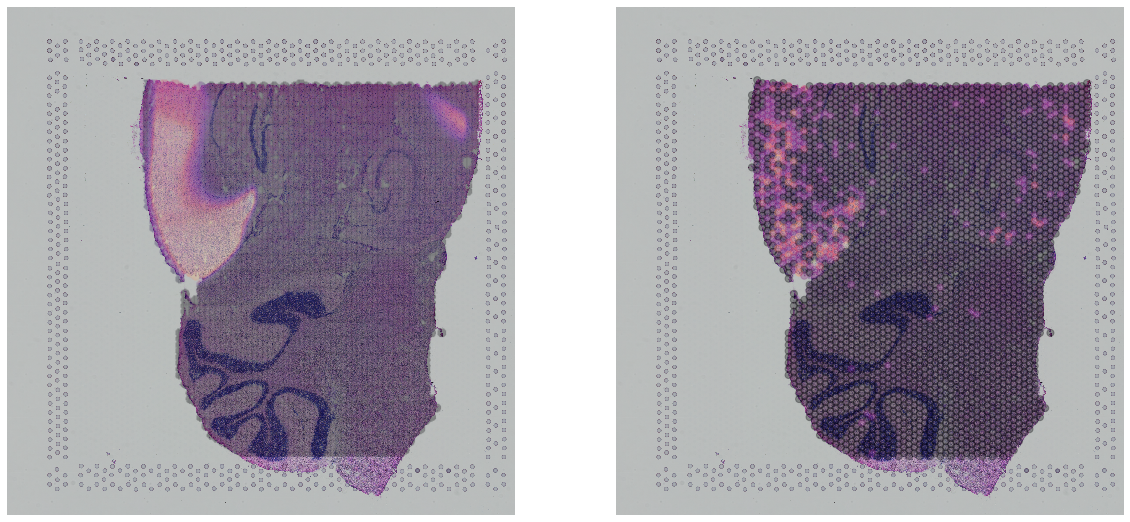

In [220]:
cmap = plt.cm.magma
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(xdata.visual["image_hires"].transpose(1,0,2))
ax[0].scatter(inter.crd[:,0]*xdata.visual["tissue_hires_scalef"],
              inter.crd[:,1]*xdata.visual["tissue_hires_scalef"],
              c=inter.values,
              s = 0.01,
              cmap = cmap,
              alpha = 0.8,
              )

ax[1].imshow(xdata.visual["image_hires"].transpose(1,0,2))
ax[1].scatter(xdata.crd[:,0]*xdata.visual["tissue_hires_scalef"],
            xdata.crd[:,1]*xdata.visual["tissue_hires_scalef"],
            c=xdata.expr[:,xdata.active].numpy(),
            s =50,
            cmap = cmap,
            alpha = 0.3)

for ii in range(2): 
    ax[ii].set_aspect("equal")
    f.clean_ax(ax[ii])
    
plt.show()


There are quite a lot of parameters that could be tweaked here, (number of neurons, activation functions, loss function, epochs, learning rate etc..) - in a more rigorous analysis, we would also prefer to split the data into a training and validation set (to guard ourselves of overfitting) which for sure happens here. Still, we do see some intriguing results despite using this very naivë approach.

However, if we attempt to analyze a gene with a slightly more irregular expression pattern, like `Car8` (up-regulated in cluster 2), it's obvious that there are some sub-optimal performance with our approach.

**NOTE** : Feel encouraged to change and play around with the network hyperparameters, see if you can improve the performance!

In [410]:
from torch.nn import ReLU, ELU, Sigmoid, CELU
t.manual_seed(1337)

# set the active gene to Car8
xdata.set_active("Car8")

# set network and training settings
n_epochs = 2000

# network hyperparameters
n_h1 = 64
n_h2 = 32
act_1 = ReLU()
act_2 = ReLU()

# assemble network
net = GeneNet(input_size = xdata.S,
              hidden1 = n_h1,
              hidden2 = n_h2,
              activation1 = act_1,
              activation2 = act_2,
              drop_p = 0.2,
             )

In [411]:
# train network
net,loss = fit(train_loader,
               model = net,
               n_epochs=n_epochs)

Epoch 0 | Loss 8.235918551683426
Epoch 100 | Loss 2.9297744184732437
Epoch 200 | Loss 2.783556491136551
Epoch 300 | Loss 2.7297565937042236
Epoch 400 | Loss 2.6559211015701294
Epoch 500 | Loss 2.4931644648313522
Epoch 600 | Loss 2.449680835008621
Epoch 700 | Loss 2.468057483434677
Epoch 800 | Loss 2.4550862312316895
Epoch 900 | Loss 2.287797510623932
Epoch 1000 | Loss 2.3178222328424454
Epoch 1100 | Loss 2.2204042226076126
Epoch 1200 | Loss 2.2096159607172012
Epoch 1300 | Loss 2.145768404006958
Epoch 1400 | Loss 2.1424208730459213
Epoch 1500 | Loss 2.123972177505493
Epoch 1600 | Loss 2.1248599886894226
Epoch 1700 | Loss 2.0630443394184113
Epoch 1800 | Loss 2.086349308490753
Epoch 1900 | Loss 2.168854370713234


In [408]:
# predct gene expression using the trained network
inter.predict(net)

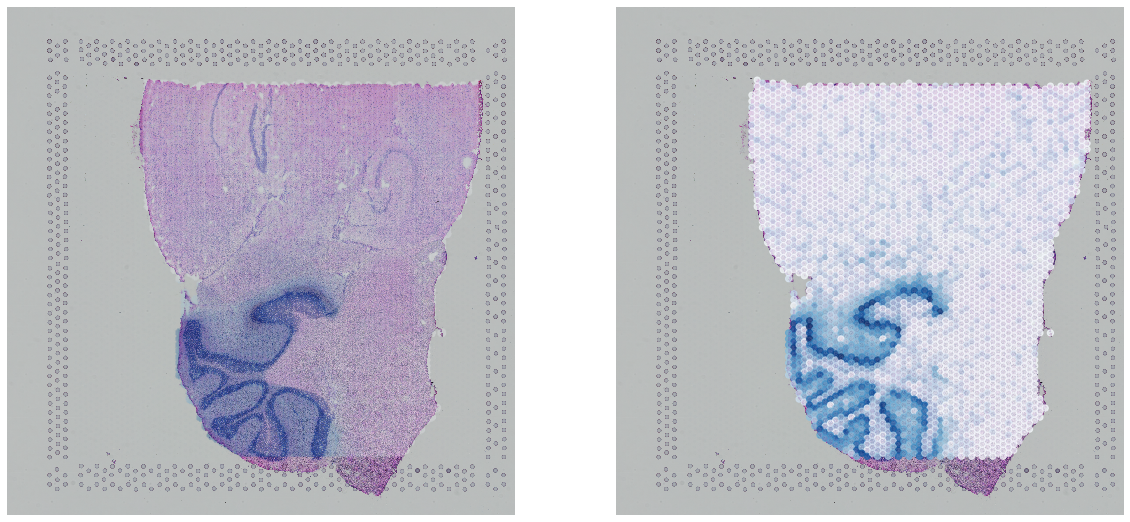

In [409]:

cmap = plt.cm.Blues
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(xdata.visual["image_hires"].transpose(1,0,2))
ax[0].scatter(inter.crd[:,0]*xdata.visual["tissue_hires_scalef"],
              inter.crd[:,1]*xdata.visual["tissue_hires_scalef"],
              c=inter.values,
              s = 0.01,
              cmap = cmap,
              alpha = 0.8,
              )

ax[1].imshow(xdata.visual["image_hires"].transpose(1,0,2))
ax[1].scatter(xdata.crd[:,0]*xdata.visual["tissue_hires_scalef"],
            xdata.crd[:,1]*xdata.visual["tissue_hires_scalef"],
            c=xdata.expr[:,xdata.active].numpy(),
            s =40,
            cmap = cmap,
            alpha = 0.7)

for ii in range(2): 
    ax[ii].set_aspect("equal")
    f.clean_ax(ax[ii])
plt.show()

We do capture some of structure of the gene expression, but the gradient along the edges of the darker area is to a large extet lost. Extended training would increase the performance somewhat, and as mentioned above, we could start tweaking the settings and changing the archichtecture of out network (try it out!).

There is however one thing we have not mentioned yet, namely the HE-image. The HE-image is extremely rich in information, for example; the expression based clusters relate to the morphology we can observe in the image. If we somewhow could base our inference on the joint information presented by the image and gene expression, we could probably do much better than this.

We will not embark upon that endavour in this exercise, but there exist a method designed for this specific purpose, developed by L. Bergenstråhle et.al. The implementation is named **xFuse** and found [here](https://github.com/ludvb/xfuse). To illustrate some of the results that you can achieve I've included one of the main figures from the preprint below:

<img src = "imgs/xfuse.png">

If these results and the ideas behind them intrigue you, then I highly recommend to give **xFuse** a look and try it out on you data.